In [1]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1200])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1200])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [5]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [6]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, gamma = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, C, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

rbf 0.3 0.016


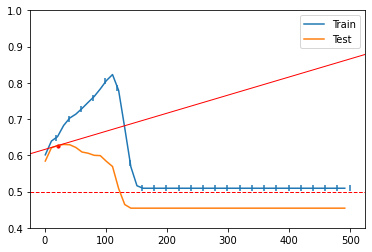

AT (21, 0.6266666666666666, 0.30706666666666677) WITH 25 ITERATIONS IN 460.9311322768529 SECONDS : 299.94842580058327
__main__.SVM_RFE_W_STEP - 00:07:58.623672300
rbf 0.3 0.018


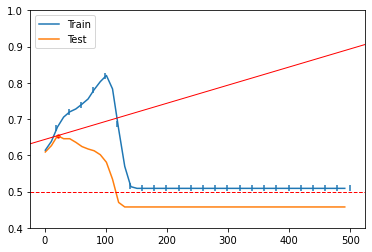

AT (21, 0.6541666666666667, 0.2850666666666667) WITH 25 ITERATIONS IN 458.2961417039235 SECONDS : 49.38477885668402
__main__.SVM_RFE_W_STEP - 00:07:48.770214000
rbf 0.3 0.02


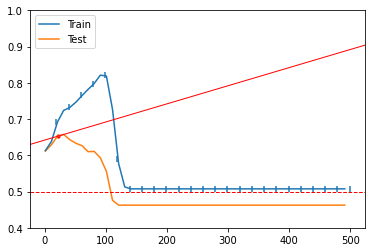

AT (21, 0.6525000000000001, 0.2864) WITH 25 ITERATIONS IN 466.3704571723938 SECONDS : 22.642445286876107
__main__.SVM_RFE_W_STEP - 00:07:56.341262700
rbf 0.3 0.022


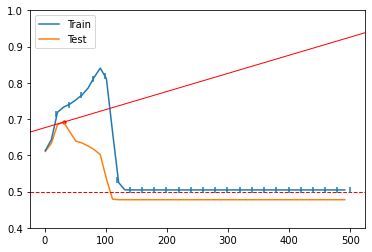

AT (31, 0.6916666666666668, 0.2590666666666666) WITH 25 ITERATIONS IN 505.1014539003372 SECONDS : 898.5948687103629
__main__.SVM_RFE_W_STEP - 00:08:52.648667600
rbf 0.3 0.024


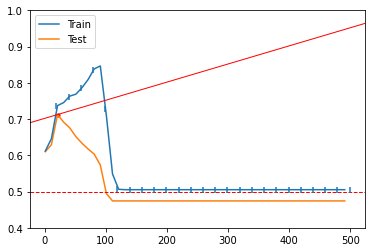

AT (21, 0.7125, 0.23839999999999997) WITH 25 ITERATIONS IN 523.2046807607015 SECONDS : 1290.385855568005
__main__.SVM_RFE_W_STEP - 00:09:14.434963600


In [7]:
SVM_RFE_W_STEP(20, 0.3, 0.016, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.018, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.022, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.024, 'rbf')

rbf 0.4 0.016


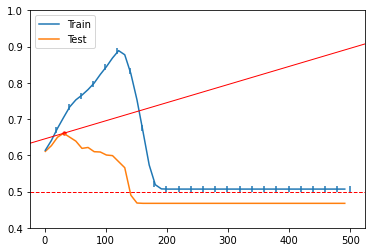

AT (31, 0.6608333333333333, 0.2837333333333334) WITH 25 ITERATIONS IN 468.4500804742177 SECONDS : 20.75817280144697
__main__.SVM_RFE_W_STEP - 00:07:58.045617400
rbf 0.4 0.018


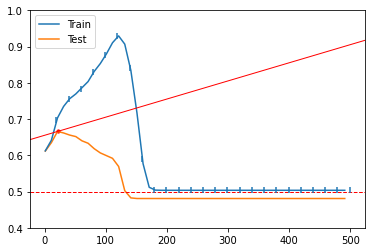

AT (21, 0.6658333333333333, 0.2757333333333334) WITH 25 ITERATIONS IN 469.6326822042465 SECONDS : 15.786591552603658
__main__.SVM_RFE_W_STEP - 00:07:59.061656800
rbf 0.4 0.02


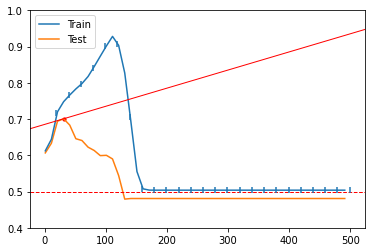

AT (31, 0.7008333333333333, 0.25173333333333336) WITH 25 ITERATIONS IN 468.990806221962 SECONDS : 39.34338261717652
__main__.SVM_RFE_W_STEP - 00:07:59.423206100
rbf 0.4 0.022


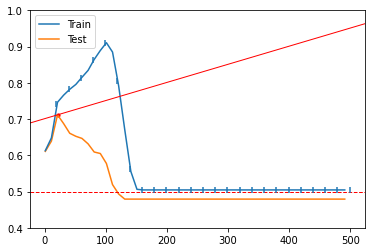

AT (21, 0.7116666666666666, 0.23906666666666676) WITH 25 ITERATIONS IN 469.0094568332036 SECONDS : 19.52598804310888
__main__.SVM_RFE_W_STEP - 00:07:58.591685000
rbf 0.4 0.024


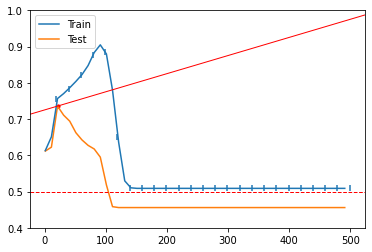

AT (21, 0.7358333333333333, 0.21973333333333334) WITH 25 ITERATIONS IN 469.492311000824 SECONDS : 16.542346416760456
__main__.SVM_RFE_W_STEP - 00:07:58.582174600


In [8]:
SVM_RFE_W_STEP(20, 0.4, 0.016, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.018, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.022, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.024, 'rbf')

rbf 0.5 0.016


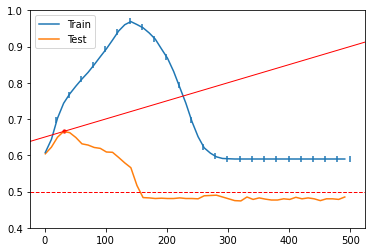

AT (31, 0.6658333333333333, 0.2797333333333334) WITH 25 ITERATIONS IN 467.5053428014119 SECONDS : 280.66223330851136
__main__.SVM_RFE_W_STEP - 00:08:04.929370400
rbf 0.5 0.018


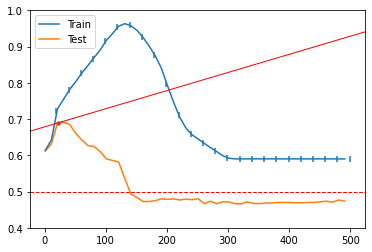

AT (21, 0.6891666666666666, 0.2570666666666667) WITH 25 ITERATIONS IN 468.8679803609848 SECONDS : 21.142800714269296
__main__.SVM_RFE_W_STEP - 00:07:58.376326600


In [9]:
SVM_RFE_W_STEP(20, 0.5, 0.016, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.018, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.022, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.024, 'rbf')

In [ ]:
SVM_RFE_W_STEP(20, 0.6, 0.016, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.018, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.022, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.024, 'rbf')